Full ANN (artificial nueral network) regression code

- how to appyly an artifical neural network to any tabular data set
- feature engineering
- feature encoding
- embeddings
- dropout layers

Steps
- Read in the data
- feature engineering
    - calculate distance
    - derive useful date and time stats
- deal with categorical dta
    - embedding
- create tabular model class
    -use tabular model class to work with continuous and categorical data
- add in loss function and optimizer
- train/test split
- train the model
- evaluate on test data
- predict on brand new data

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
#use .. to go up one level in the directory

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [5]:
#copy and pasted from library notebook
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [7]:
#feature engineering
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [8]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


Feature engineering is taking existing features and creating a new feature that is more useful than the feautres you already have
- we took long and lat to feature engineer distacne in km

Now we will do it on the date time object

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
pickup_datetime      120000 non-null datetime64[ns, UTC]
fare_amount          120000 non-null float64
fare_class           120000 non-null int64
pickup_longitude     120000 non-null float64
pickup_latitude      120000 non-null float64
dropoff_longitude    120000 non-null float64
dropoff_latitude     120000 non-null float64
passenger_count      120000 non-null int64
dist_km              120000 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [11]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [12]:
my_time = df['pickup_datetime'][0]

In [13]:
#my_time. tab will show you all the things you can grab
my_time.hour

8

In [14]:
#change to correct time zone
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [15]:
df['Hour'] = df['EDTdate'].dt.hour

In [16]:
df['AMorPM'] = np.where(df['Hour'] < 12, 'AM', 'PM')

In [17]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
# %a returns weekday
# can also use dt.dayofweek which returns number of day of week
# could then map to day of the week

In [18]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM,Fri


Separate categorical from continuous variables

In [19]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
# hours could be continuous or categorical, we will do categorical, 24 categories
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [20]:
y_col = ['fare_amount']

In [21]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [22]:
#use pandas to change data type to category
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [23]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [24]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [25]:
df['AMorPM'].head()

0    AM
1    AM
2    AM
3    PM
4    PM
Name: AMorPM, dtype: category
Categories (2, object): [AM, PM]

In [26]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

There are category codes and categories

In [27]:
df['AMorPM'].cat.categories

Index(['AM', 'PM'], dtype='object')

In [28]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
5         0
6         1
7         0
8         0
9         1
10        1
11        1
12        0
13        1
14        0
15        1
16        1
17        0
18        1
19        1
20        0
21        0
22        0
23        1
24        0
25        0
26        1
27        1
28        1
29        1
         ..
119970    0
119971    1
119972    0
119973    1
119974    0
119975    1
119976    1
119977    0
119978    1
119979    0
119980    0
119981    0
119982    1
119983    1
119984    1
119985    1
119986    1
119987    0
119988    0
119989    1
119990    0
119991    1
119992    0
119993    0
119994    1
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [29]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [30]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
5         4
6         0
7         4
8         5
9         0
10        4
11        4
12        0
13        2
14        6
15        5
16        4
17        4
18        6
19        5
20        5
21        1
22        5
23        5
24        6
25        2
26        3
27        4
28        0
29        5
         ..
119970    3
119971    4
119972    0
119973    2
119974    2
119975    5
119976    5
119977    5
119978    3
119979    6
119980    6
119981    4
119982    6
119983    6
119984    0
119985    1
119986    0
119987    1
119988    3
119989    2
119990    3
119991    1
119992    0
119993    1
119994    3
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [31]:
#adding .values makes it a numpy array
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [32]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [33]:
cats = np.stack([hr,ampm,wkdy], axis=1)

In [34]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [35]:
# can do it all as three lines of code, the above just breaks it down to show what is happening

#cat_cols = ['Hour', 'AMorPM', 'Weekday']
#for cat in cat_cols:
    #df[cat] = df[cat].astype('category')
#cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

In [36]:
cats = torch.tensor(cats, dtype = torch.int64)

In [37]:
# now do for continuous variables
conts = np.stack([df[col].values for col in cont_cols], axis = 1)

In [38]:
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

In [39]:
conts = torch.tensor(conts, dtype = torch.float)

In [40]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

Now both continuous and categorical variables are pytorch tensors

In [41]:
y = torch.tensor(df[y_col].values, dtype = torch.float)
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [42]:
cats.shape

torch.Size([120000, 3])

In [43]:
conts.shape

torch.Size([120000, 6])

In [44]:
y.shape

torch.Size([120000, 1])

Embedding
- a simple lookup table that stores embeddings of a fixed dictinoary and size
- esentially one hot encoding (dummy coding)

In [45]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [46]:
cat_szs

[24, 2, 7]

In [47]:
# divide number of unqiue entries in each column by two, max out at about 50
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
#for 24, 2, 7 it with either take 50 or divide it by 2

In [48]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

Define a tabular model and set up network

In [49]:
catz = cats[:2]

In [50]:
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [51]:
selfembeds = nn.ModuleList(nn.Embedding(ni,nf) for ni,nf in emb_szs)

In [52]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [53]:
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

In [54]:
embeddingz

[tensor([[ 1.2339, -0.9228,  0.5953,  1.7137,  0.2648,  1.4322,  0.0719, -0.6219,
           0.8960, -0.0075, -2.0012, -0.8573],
         [ 0.7420, -0.2264, -0.9584,  0.7470, -0.7251,  0.7416, -0.3308,  0.0300,
          -0.1554, -0.1170,  0.8391,  0.8502]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.0373],
         [-1.0373]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.3077, -1.8273, -0.0377, -1.4218],
         [ 0.1017, -1.1525, -0.3917,  1.1575]], grad_fn=<EmbeddingBackward>)]

We have 24 items in the first tensor, 2 in the second, 7 in the last

In [55]:
z = torch.cat(embeddingz, 1)

In [56]:
z

tensor([[ 1.2339, -0.9228,  0.5953,  1.7137,  0.2648,  1.4322,  0.0719, -0.6219,
          0.8960, -0.0075, -2.0012, -0.8573, -1.0373, -1.3077, -1.8273, -0.0377,
         -1.4218],
        [ 0.7420, -0.2264, -0.9584,  0.7470, -0.7251,  0.7416, -0.3308,  0.0300,
         -0.1554, -0.1170,  0.8391,  0.8502, -1.0373,  0.1017, -1.1525, -0.3917,
          1.1575]], grad_fn=<CatBackward>)

In [57]:
selfembdrop = nn.Dropout(0.4) 
#randomly zero some of the elmenets of the input tensor with whatever probability you provide
#that way you dont overfit the model

In [58]:
z = selfembdrop(z)

In [59]:
z

tensor([[ 2.0565, -1.5379,  0.0000,  2.8562,  0.4413,  0.0000,  0.1198, -1.0364,
          1.4933, -0.0124, -3.3354, -1.4288, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000],
        [ 0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.2590, -0.1950,  0.0000,  1.4170, -1.7288,  0.1695, -1.9208, -0.0000,
          1.9291]], grad_fn=<MulBackward0>)

What we did
- during the forward method we build out the embedding layer
- each embedding layer corresponds to one of the categorical variables
- then we assign numerical value to the one hot encoding
- put them all together in one tensor
- pass through a dropout layer and get assigned values

In [60]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # this setup allows us to use Layers = [n, n1, n2]
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont) #normalize
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [61]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [62]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [63]:
criterion = nn.MSELoss() #np.sqrt(MSE) -> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [64]:
#train/test split
batch_size = 60000
test_size = int(batch_size*0.2) #make an integer rather than a float

In [65]:
# Data shuffled already
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [66]:
len(cat_train)

48000

In [67]:
len(con_train)

48000

In [68]:
len(cat_test)

12000

In [69]:
import time

start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train,con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))#RMSE
    losses.append(loss)
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time
print(f'Training took {duration/60} minutes')

epoch: 1 loss is 12.500558853149414
epoch: 11 loss is 12.160984992980957
epoch: 21 loss is 11.738170623779297
epoch: 31 loss is 11.323526382446289
epoch: 41 loss is 10.903594970703125
epoch: 51 loss is 10.480284690856934
epoch: 61 loss is 10.078514099121094
epoch: 71 loss is 9.706099510192871
epoch: 81 loss is 9.366927146911621
epoch: 91 loss is 9.055989265441895
epoch: 101 loss is 8.731250762939453
epoch: 111 loss is 8.3931245803833
epoch: 121 loss is 8.016782760620117
epoch: 131 loss is 7.6094489097595215
epoch: 141 loss is 7.1871466636657715
epoch: 151 loss is 6.718172073364258
epoch: 161 loss is 6.239389896392822
epoch: 171 loss is 5.744295597076416
epoch: 181 loss is 5.25827693939209
epoch: 191 loss is 4.800881862640381
epoch: 201 loss is 4.361302852630615
epoch: 211 loss is 4.014430046081543
epoch: 221 loss is 3.7611608505249023
epoch: 231 loss is 3.619093418121338
epoch: 241 loss is 3.524198055267334
epoch: 251 loss is 3.493269205093384
epoch: 261 loss is 3.4458730220794678
epoc

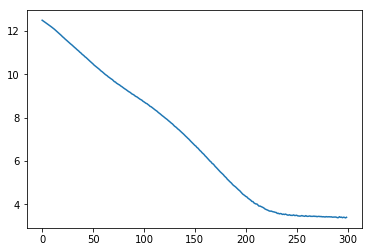

In [70]:
plt.plot(range(epochs),losses)

In [72]:
#validate model on test set
with torch.no_grad():
    
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val,y_test))

In [73]:
loss

tensor(3.3224)

similar to the training set

In [77]:
#predicted vs actual
for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i}.) PREDICTED:{y_val[i].item():8.2f} TRUE: {y_test[i].item():8.2f} DIFF: {diff:8.2f}')
    
    #8.2f just formats the floating point

0.) PREDICTED:    3.67 TRUE:     2.90 DIFF:     0.77
1.) PREDICTED:   25.67 TRUE:     5.70 DIFF:    19.97
2.) PREDICTED:    6.29 TRUE:     7.70 DIFF:     1.41
3.) PREDICTED:   13.34 TRUE:    12.50 DIFF:     0.84
4.) PREDICTED:    4.72 TRUE:     4.10 DIFF:     0.62
5.) PREDICTED:    5.46 TRUE:     5.30 DIFF:     0.16
6.) PREDICTED:    4.25 TRUE:     3.70 DIFF:     0.55
7.) PREDICTED:   17.55 TRUE:    14.50 DIFF:     3.05
8.) PREDICTED:    7.20 TRUE:     5.70 DIFF:     1.50
9.) PREDICTED:   11.45 TRUE:    10.10 DIFF:     1.35


some of the raw differences are far off but the overall rmse is doing good as shown in loss

In [78]:
#save the model
torch.save(model.state_dict(),'TaxiModel.pt')

CLASSIFICATION EXAMPLE

In [80]:
#difference column to use
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

Then follow all the same steps as above for the regression until we get to creating the model

- Change in the output size to 2
- this would be set to however many classes you had (categories)

In [82]:
#torch.manual_seed(33)
#model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

Then when we get to the cirterion and optimizer, replace MSE loss function with cross entropy loss

In [83]:
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

still perform train test split, train the model, plot loss function, look at accuracy of predicted values, save the model